In [1]:
# Install all necessary libraries for our XAI framework
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib alibi captum pdpbox eli5


Dataset prep


In [2]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Change the path to where your dataset is stored in Drive
dataset_path = '/content/drive/MyDrive/Crop_recommendation.csv'
df = pd.read_csv(dataset_path)

# Preview first rows
df.head()


Mounted at /content/drive


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
# Check for data quality issues
# Check dataset shape (rows, columns)
print("Dataset shape:", df.shape)

# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Show basic dataset info
print("\nDataset info:")
df.info()

# Quick look at unique crop types
print("\nUnique crops (target labels):", df['label'].unique())
print("Total crop classes:", df['label'].nunique())


Dataset shape: (2200, 8)

Missing values per column:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Number of duplicate rows: 0

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB

Unique crops (target labels): ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'g

In [4]:
from sklearn.preprocessing import LabelEncoder

# Separate features (X) and target (y)
X = df.drop('label', axis=1)  # all feature columns
y = df['label']               # target column (crop names)

# Encode target labels into numeric codes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Show mapping (crop name -> numeric code)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Crop Label Mapping (Crop Name -> Code):")
for crop, code in label_mapping.items():
    print(f"{crop}: {code}")

# Check shape of X and y
print("\nFeatures shape:", X.shape)
print("Encoded labels shape:", y_encoded.shape)


Crop Label Mapping (Crop Name -> Code):
apple: 0
banana: 1
blackgram: 2
chickpea: 3
coconut: 4
coffee: 5
cotton: 6
grapes: 7
jute: 8
kidneybeans: 9
lentil: 10
maize: 11
mango: 12
mothbeans: 13
mungbean: 14
muskmelon: 15
orange: 16
papaya: 17
pigeonpeas: 18
pomegranate: 19
rice: 20
watermelon: 21

Features shape: (2200, 7)
Encoded labels shape: (2200,)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# --- Split the data (80% train, 20% test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# --- Scale the features (StandardScaler) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaled Feature Mean (approx):", X_train_scaled.mean(axis=0))
print("Scaled Feature Std (approx):", X_train_scaled.std(axis=0))

# --- Save all files directly to Google Drive ---
save_path = '/content/drive/MyDrive/'

joblib.dump(X_train_scaled, save_path + 'X_train.pkl')
joblib.dump(X_test_scaled, save_path + 'X_test.pkl')
joblib.dump(y_train, save_path + 'y_train.pkl')
joblib.dump(y_test, save_path + 'y_test.pkl')
joblib.dump(scaler, save_path + 'scaler.pkl')
joblib.dump(label_encoder, save_path + 'label_encoder.pkl')

print(f"\nAll preprocessed files saved in: {save_path}")


Training set size: 1760
Testing set size: 440

Scaled Feature Mean (approx): [ 2.82602224e-17  8.07434927e-17  5.55111512e-17 -2.82602224e-16
 -1.46347581e-16 -4.52163559e-16  2.22044605e-16]
Scaled Feature Std (approx): [1. 1. 1. 1. 1. 1. 1.]

All preprocessed files saved in: /content/drive/MyDrive/


In [6]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# --- Load preprocessed data from Google Drive ---
save_path = '/content/drive/MyDrive/'

X_train = joblib.load(save_path + 'X_train.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')
y_train = joblib.load(save_path + 'y_train.pkl')
y_test = joblib.load(save_path + 'y_test.pkl')

# --- Initialize models ---
models = {
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42, use_label_encoder=False),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42)
}

# --- Train and evaluate models ---
model_accuracies = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    model_accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

    # Save each trained model
    joblib.dump(model, save_path + f"{name}_model.pkl")

print("\nAll models trained and saved!")
print("Model Accuracies:", model_accuracies)


Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:01:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9932
Training RandomForest...
RandomForest Accuracy: 0.9955
Training SVM...
SVM Accuracy: 0.9818
Training MLP...
MLP Accuracy: 0.9909
Training LogisticRegression...
LogisticRegression Accuracy: 0.9727

All models trained and saved!
Model Accuracies: {'XGBoost': 0.9931818181818182, 'RandomForest': 0.9954545454545455, 'SVM': 0.9818181818181818, 'MLP': 0.990909090909091, 'LogisticRegression': 0.9727272727272728}


Singular model training

Final SHAP values shape: (440, 7)
X_test_df shape: (440, 7)

Generating SHAP summary plot...


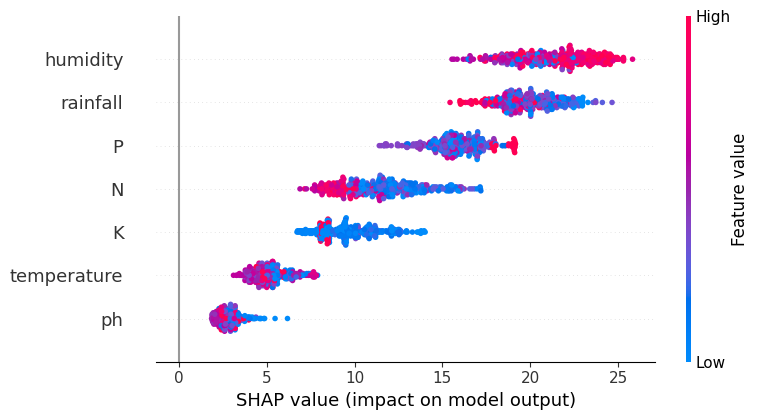


Explaining instance #10
True Crop: watermelon | Predicted Crop: watermelon


In [15]:
import shap
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Load model and data ---
save_path = '/content/drive/MyDrive/'
xgb_model = joblib.load(save_path + 'XGBoost_model.pkl')
X_test = joblib.load(save_path + 'X_test.pkl')
y_test = joblib.load(save_path + 'y_test.pkl')
label_encoder = joblib.load(save_path + 'label_encoder.pkl')

feature_names = ['N','P','K','temperature','humidity','ph','rainfall']
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# --- Create SHAP Explainer and get unified SHAP values ---
explainer = shap.TreeExplainer(xgb_model)
shap_exp = explainer(X_test_df)  # returns a unified SHAP Explanation object

# For global importance, sum absolute SHAP values across all classes automatically
shap_values = np.abs(shap_exp.values).sum(axis=2)  # (440, 7)

print("Final SHAP values shape:", shap_values.shape)
print("X_test_df shape:", X_test_df.shape)

# --- GLOBAL SHAP SUMMARY PLOT ---
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values, X_test_df, feature_names=feature_names, show=True)

# --- LOCAL SHAP FORCE PLOT (Fixed) ---
instance_idx = 10
instance_data = X_test_df.iloc[instance_idx]
instance_true_class = y_test[instance_idx]
instance_pred_class = xgb_model.predict(instance_data.values.reshape(1, -1))[0]

true_crop = label_encoder.inverse_transform([instance_true_class])[0]
pred_crop = label_encoder.inverse_transform([instance_pred_class])[0]

print(f"\nExplaining instance #{instance_idx}")
print(f"True Crop: {true_crop} | Predicted Crop: {pred_crop}")

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[instance_pred_class],  # use class index, not string
    shap_values=shap_exp.values[instance_idx, :, instance_pred_class],  # SHAP for predicted class
    features=instance_data.values,
    feature_names=feature_names
)
